# Interview challenge for PayPay.
Data: markplace web session log on `data` folder

Machine Learning Processing & Analytical goal:
    
    - Predict the expected load (requests/second) in the next minute

In [3]:
# Libraries and setup
# Auto reload changes
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

# source dependencies, log_file_schema & data handler
from src.dependencies import *
from src.log_file_schema import schema
from src.data_handler import DataHandler

# plot lib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# forcasting lib and matrics
# https://facebook.github.io/prophet/
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# create or get spark session
spark = SparkSession.builder \
    .master("local[*]")\
    .appName("PayPay_DS_Challange")\
    .getOrCreate()

In [5]:
def preprocess_data(spark):
    """
    Process data

    @param spark: spark session
    """
    df = spark.read.csv(log_file, schema=schema, sep=" ").repartition(num_partitions).cache()
    
    df = df.withColumn("time", col("timestamp").cast("timestamp")) \
           .withColumn("load",lit(1)) \
           .drop("client:port", "backend:port","request","timestamp", "elb", "request_processing_time",
              "backend_processing_time", "response_processing_time", "elb_status_code",
              "backend_status_code", "received_bytes", "sent_bytes", "user_agent", "ssl_cipher", "ssl_protocol")

    df = df.withColumn("time", from_unixtime(unix_timestamp(col("time"), "yyyy-MM-dd HH:mm:ss.SSSSSS"),"yyyy-MM-dd HH:mm:ss"))
    df = df.groupby("time").agg(sum("load").alias("load")).cache()
    df = df.orderBy(col("time"))
    
    return df


def data_loader(spark):
    """
    Data loader
    
    @param spark: spark session
    """
    data_set = preprocess_data(spark).cache()
    data_set.show()
    
    return data_set.select("*").toPandas()

df=data_loader(spark)

+-------------------+----+
|               time|load|
+-------------------+----+
|2015-07-22 11:40:06|  27|
|2015-07-22 11:40:07|  62|
|2015-07-22 11:40:08|  56|
|2015-07-22 11:40:09| 112|
|2015-07-22 11:40:10|  58|
|2015-07-22 11:40:11|  58|
|2015-07-22 11:40:12|  67|
|2015-07-22 11:40:13|  85|
|2015-07-22 11:40:14| 160|
|2015-07-22 11:40:15|  57|
|2015-07-22 11:40:16|  99|
|2015-07-22 11:40:17|  96|
|2015-07-22 11:40:18|  95|
|2015-07-22 11:40:19|  65|
|2015-07-22 11:40:20| 130|
|2015-07-22 11:40:21|  65|
|2015-07-22 11:40:22|  59|
|2015-07-22 11:40:23|  62|
|2015-07-22 11:40:24|  89|
|2015-07-22 11:40:25| 130|
+-------------------+----+
only showing top 20 rows



In [6]:
print(df.head())
print(df.shape)

                  time  load
0  2015-07-22 11:40:06    27
1  2015-07-22 11:40:07    62
2  2015-07-22 11:40:08    56
3  2015-07-22 11:40:09   112
4  2015-07-22 11:40:10    58
(4269, 2)


In [50]:
data_indexed_date = df.set_index("time")
data_indexed_date_train = data_indexed_date[:-600]
data_indexed_date_test  = data_indexed_date[-600:]

data_indexed_date_train = data_indexed_date_train[["load"]]
data_indexed_date_test  = data_indexed_date_test[["load"]]

print('training data:', data_indexed_date_train.shape)
print('test data:', data_indexed_date_test.shape)
print('Total data:', data_indexed_date_train.shape[0] + data_indexed_date_test.shape[0])

training data: (3669, 1)
test data: (600, 1)
Total data: 4269


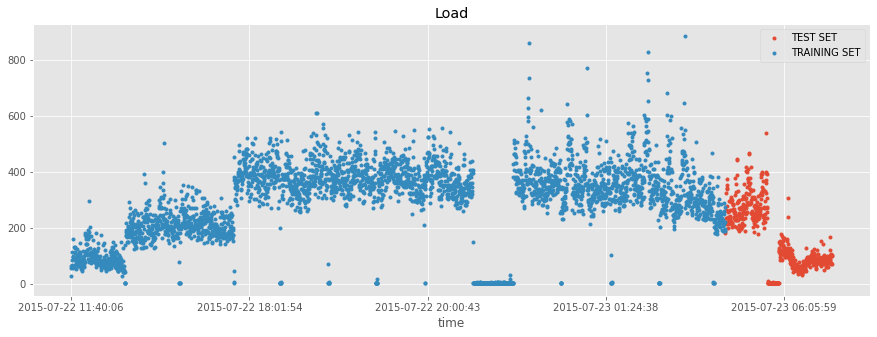

In [51]:
_ = data_indexed_date_test \
    .rename(columns={'load': 'TEST SET'}) \
    .join(data_indexed_date_train.rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Load', style='.')

In [52]:
data_indexed_date_train.reset_index().rename(columns={'time':'x', 'load':'y'}).head()

,x,y
0,2015-07-22 11:40:06,27
1,2015-07-22 11:40:07,62
2,2015-07-22 11:40:08,56
3,2015-07-22 11:40:09,112
4,2015-07-22 11:40:10,58


In [53]:
# forcasting lib and matrics
# https://facebook.github.io/prophet/
model = Prophet()
model.fit(data_indexed_date_train.reset_index().rename(columns={'time':'ds', 'load':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
data_indexed_date_test_fcst = model.predict(df=data_indexed_date_test.reset_index().rename(columns={'time':'ds'}))

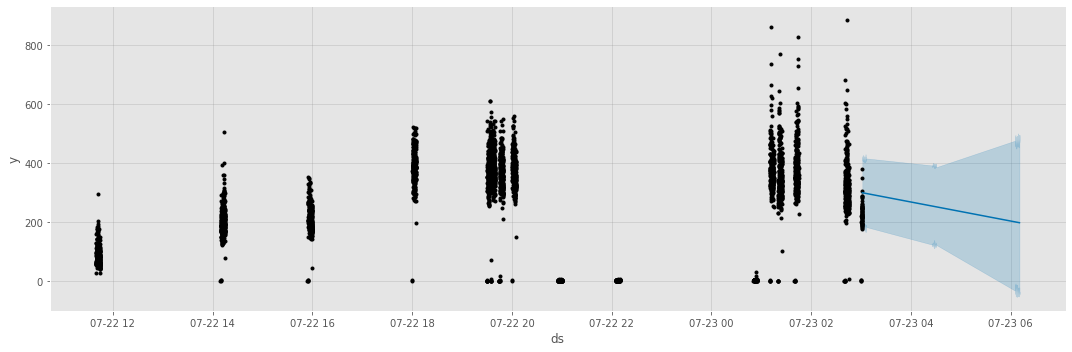

In [55]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_indexed_date_test_fcst, ax=ax)

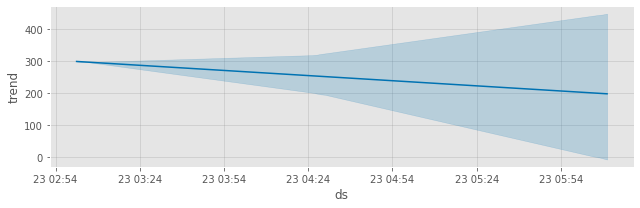

In [56]:
fig = model.plot_components(data_indexed_date_test_fcst)


In [57]:
mean_squared_error(y_true=data_indexed_date_test['load'],
                   y_pred=data_indexed_date_test_fcst['yhat'])

14894.452175545066

In [58]:
mean_absolute_error(y_true=data_indexed_date_test['load'],
                   y_pred=data_indexed_date_test_fcst['yhat'])




103.63974055772356

In [59]:
data_indexed_date_test_fcst.reset_index().rename(columns={'ds':'x', 'yhat':'y'}).head()

,index,x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,y
0,0,2015-07-23 03:01:30,299.378463,184.270592,412.406316,299.378463,299.378463,0.0,0.0,0.0,0.0,0.0,0.0,299.378463
1,1,2015-07-23 03:01:31,299.369501,184.119836,414.970046,299.369501,299.369501,0.0,0.0,0.0,0.0,0.0,0.0,299.369501
2,2,2015-07-23 03:01:32,299.360539,185.464038,411.858033,299.360539,299.360539,0.0,0.0,0.0,0.0,0.0,0.0,299.360539
3,3,2015-07-23 03:01:33,299.351577,186.376830,416.041299,299.351577,299.351577,0.0,0.0,0.0,0.0,0.0,0.0,299.351577
4,4,2015-07-23 03:01:34,299.342615,186.453555,415.299417,299.342615,299.342615,0.0,0.0,0.0,0.0,0.0,0.0,299.342615
